# Deep Convolutional GAN


## Introduction

The dataset you will be using is the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

The success of the DCGAN will be tested as follows:
  - **By the model's training error**. Need to achieve relatively balanced errors for the generator and the discriminator of your model in order to sample realistic images from the generator. Visualisation of training losses curves and visualisations of generated samples in the respective cells. 
  - **By avoiding mode collapse**. A common problem of training GANs is that they end up generating only a few different samples (if not only one), rather than learning the whole distribution of the training data. This problem is referred to as mode collapse. 

In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))


### Device Selection

In [0]:
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cuda:0


### Reproducibility

In [0]:
# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

### Data loading

In [0]:
batch_size = 128

if not os.path.exists('./CW/CAE'):
    os.makedirs('./CW/CAE')
if not os.path.exists('./CW/DCGAN'):
    os.makedirs('./CW/DCGAN')


NUM_TRAIN = 49000

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


data_dir = './datasets'
cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transform)
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
                           transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar10_val, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]
save_image(denorm(fixed_input), './CW/CAE/input_sample.png')

  0%|          | 0/170498071 [00:00<?, ?it/s]

100%|█████████▉| 170287104/170498071 [00:44<00:00, 2645528.15it/s]

Files already downloaded and verified
Files already downloaded and verified


## DCGAN - Deep Convolutional GAN

In this task, the main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. 

### Hyper-parameter selection

In [0]:
### Choose the number of epoch, the learning rate
#   and the size of the Generator's input noise vetor.
num_epochs = 20
learning_rate  = 0.001
latent_vector_size = 128
###


In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.deconv1 = nn.ConvTranspose2d( latent_vector_size, 64 * 8, 4, 1, 0, bias=False)
        self.norm1 = nn.BatchNorm2d(64 * 8)
        self.relu = nn.ReLU(True)
        self.deconv2 = nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False)
        self.norm2 = nn.BatchNorm2d(64 * 4)
        self.deconv3 = nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False)
        self.norm3 = nn.BatchNorm2d(64 * 2)
        
        self.deconv4 = nn.ConvTranspose2d( 64 * 2, 3, 4, 2, 1, bias=False)
        self.tanh = nn.Tanh()
        

    def decode(self, z):
        
        z = self.relu(self.norm1(self.deconv1(z))) # b, 16, 5, 5
        z = self.relu(self.norm2(self.deconv2(z))) # b, 8, 15, 15
        z = self.relu(self.norm3(self.deconv3(z))) # b, 1, 28, 28
        z = self.tanh(self.deconv4(z))
        return z

    def forward(self, z):
        return self.decode(z)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1, bias=False)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False)
        self.norm2 = nn.BatchNorm2d(64 * 2)
        self.conv3 = nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False)
        self.norm3 = nn.BatchNorm2d(64 * 4)
        self.conv4 = nn.Conv2d(64 * 4, 1, 5, 2, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

        
    def discriminator(self, x):

        x = self.lrelu(self.conv1(x))
        x = self.lrelu(self.norm2(self.conv2(x)))
        x = self.lrelu(self.norm3(self.conv3(x)))
        x = self.conv4(x)

        
        return self.sigmoid(x)

    def forward(self, x):
        out = self.discriminator(x)
        return out.view(-1, 1).squeeze(1)

### Initialize Model and print number of parameters

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [0]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 3677952
Generator(
  (deconv1): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (deconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tanh): Tanh()
)


Total number of parameters in Discriminator is: 665600
Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (lrelu): LeakyReLU(negative_slope=0.2, inplace)
  (conv2): Conv2d(

### Define loss function

In [0]:
criterion = nn.BCELoss(reduction='mean')
def loss_function(out, label):
    loss = criterion(out, label)
    return loss

### Choose and initialize optimizers

In [0]:
# setup optimizer
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))

### Define fixed input vectors to monitor training and mode collapse.

In [0]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
real_label = 1
fake_label = 0

### Train

In [0]:
export_folder = './CW/DCGAN'
train_losses_G = []
train_losses_D = []

for epoch in range(num_epochs):
    for i, data in enumerate(loader_train, 0):
        train_loss_D = 0
        train_loss_G = 0
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        model_D.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)
        output = model_D(real_cpu)
        errD_real = loss_function(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
        fake = model_G(noise)
        label.fill_(fake_label)
        output = model_D(fake.detach())
        errD_fake = loss_function(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        train_loss_D += errD.item()
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        model_G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = model_D(fake)
        errG = loss_function(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        train_loss_G += errG.item()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(loader_train),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()), './CW/DCGAN/real_samples.png')
    
    fake = model_G(fixed_noise)
    save_image(denorm(fake.cpu()), './CW/DCGAN/fake_samples_epoch_%03d.png' % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))
            
# save losses and models
np.save('./CW/DCGAN/train_losses_D.npy', train_losses_D)
np.save('./CW/DCGAN/train_losses_G.npy', train_losses_G)
torch.save(model_G.state_dict(), './CW/DCGAN/DCGAN_model_G.pth')
torch.save(model_D.state_dict(), './CW/DCGAN/DCGAN_model_D.pth')

[0/20][0/383] Loss_D: 1.4529 Loss_G: 10.3259 D(x): 0.5668 D(G(z)): 0.5339 / 0.0001
[0/20][1/383] Loss_D: 7.7651 Loss_G: 8.1449 D(x): 0.6753 D(G(z)): 0.9989 / 0.0004
[0/20][2/383] Loss_D: 3.4243 Loss_G: 12.4216 D(x): 0.5602 D(G(z)): 0.9234 / 0.0000
[0/20][3/383] Loss_D: 1.6579 Loss_G: 7.4275 D(x): 0.3140 D(G(z)): 0.0096 / 0.0008
[0/20][4/383] Loss_D: 6.8293 Loss_G: 10.1321 D(x): 0.7301 D(G(z)): 0.9981 / 0.0000
[0/20][5/383] Loss_D: 0.6059 Loss_G: 9.9572 D(x): 0.6790 D(G(z)): 0.0018 / 0.0001
[0/20][6/383] Loss_D: 0.4317 Loss_G: 5.5866 D(x): 0.7240 D(G(z)): 0.0199 / 0.0041
[0/20][7/383] Loss_D: 6.4370 Loss_G: 10.3075 D(x): 0.8782 D(G(z)): 0.9980 / 0.0000
[0/20][8/383] Loss_D: 0.4143 Loss_G: 10.6904 D(x): 0.7219 D(G(z)): 0.0006 / 0.0000
[0/20][9/383] Loss_D: 0.3475 Loss_G: 8.0778 D(x): 0.7509 D(G(z)): 0.0009 / 0.0003
[0/20][10/383] Loss_D: 0.7586 Loss_G: 10.9029 D(x): 0.8757 D(G(z)): 0.4555 / 0.0000
[0/20][11/383] Loss_D: 0.2426 Loss_G: 10.8319 D(x): 0.8076 D(G(z)): 0.0004 / 0.0000
[0/20][

In [1]:
The architecture uses batch normalisation as it has been proven that it enables to learn faster. 
We also used leaky-RelU proposed in the paper to overcome the issue of vanishing gradient for negative inputs.

SyntaxError: ignored

### Generator samples

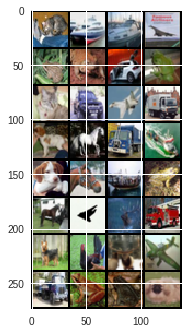

In [0]:
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=4, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)

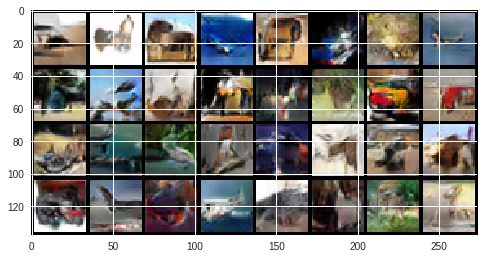

In [0]:
# load the model
model_G.load_state_dict(torch.load('./CW/DCGAN/DCGAN_model_G.pth'))
input_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:32], nrow=8, padding=2, normalize=False, 
                        range=None, scale_each=False, pad_value=0)
    show(generated)

### Train losses curves


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses/

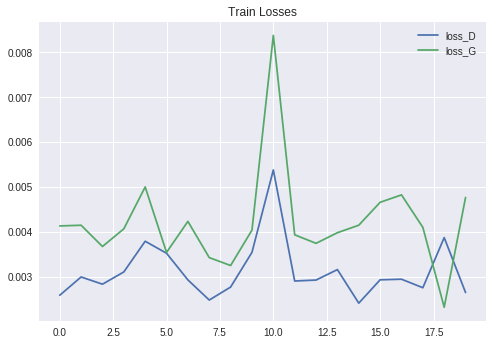

In [0]:
import matplotlib.pyplot as plt
train_losses_D = np.load('./CW/DCGAN/train_losses_D.npy')
train_losses_G = np.load('./CW/DCGAN/train_losses_G.npy')
plt.plot(list(range(0,train_losses_D.shape[0])), train_losses_D, label='loss_D')
plt.plot(list(range(0,train_losses_G.shape[0])), train_losses_G, label='loss_G')
plt.legend()
plt.title('Train Losses')
plt.show()

In [0]:
# Discussion on the training

The training of a GAN is basically solving a zero-sum game. 
It is supposed to converge when the discriminator is not able to differenciate between the real and fake images, and achieves an accuracy of 50%.
We can see in the plots that the model has not converged yet and the loss is instable for both the discriminator and the generator. 
The losses oscillates during the first epochs of training and this is expected, because each part of the network tries to beat the counterpart. 

In [0]:
# Discussion of mode collapse

One can notice two different mode collapse problems:
1) Complete mode collapse: the generator is only able to predict one single image
2) Partial mode collapse: the generator predicts similar images that belongs to one or a subset of all classes that are used, and the generated samples lacks diversity.
  
In order to overcome these problems, one can:
1) Use multiple GANs: we can use a single GAN for each class
2) Modify the loss function of the generator in order to encourage diversity: just add a term in the loss of the generator that measures the diversity in each batch.
3) Anticipate counterplay: This approach gives an opportunity for each player to anticipate the counterplay when updating in the future. 
  This will prevent the generator to jump between two modes and never being able to predict more than one mode.
  However, this increases computational time.